# Building the Baseline Model using K-Means

In [141]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from collections import Counter 

import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

In [2]:
# Grab dataframe containing police reports
# Create df on Macbook
# df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_1_data/merged.csv")

# Create df on PC
df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_1_data/merged.csv")
df = df.drop(columns='Unnamed: 0')

In [109]:
def label_hour(row):
    """Return either monring, afternoon, evening, or night depending on the hour of the day"""
    hour = int(row["Incident Hour"])
    if hour >= 5 and hour < 12: #5:00am to 11:59am
        return 'morning'
    elif hour >= 12 and hour < 17: #12:00pm to 4:59pm
        return 'afternoon'
    elif hour >= 17 and hour < 21: # 5:00pm to 8:59pm
        return 'evening'
    return 'night' # 9:00pm to 4:49am


def label_season(row):
    """Return either spring, summer, fall, or winter depending on the month of the year"""
    month = row["Incident Month"]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    winter = [12, 1, 2]
    
    if month in spring:
        return 'spring'
    elif month in summer:
        return 'summer'
    elif month in fall:
        return 'fall'
    return 'winter'

# Add "Hour" and "Month" columns
df["Incident Month"] = pd.to_datetime(df["Incident Date"]).dt.month
df["Incident Hour"] = df["Incident Time"].str.split(':').str[0]

# Add "season" and "time categories" columns
df['Time Category'] = df.apply(lambda row: label_hour(row), axis=1)
df['Season'] = df.apply(lambda row: label_season(row), axis=1)

# Generating dummy variables for categorical features
I am deciding to focus on a smaller dataset of 5000 crime reports to generate my initial baseline model for k-means. I sampled 5000 reports from the Crime Data Warehouse data (reports from 2018 onward in my original data frame).

In [4]:
# Crime Data Warehouse Data Frame
cdw_df = df[df["Incident Year"] > 2017]
cdw_df["Incident Hour"] = cdw_df["Incident Hour"].astype(int)

C:\Users\Garrett\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# Create dummy variables for categorical crime features to be used for k-means model
dummies_df = pd.get_dummies(data=cdw_df, columns=["Incident Category", "Incident Day of Week", "Police District"])
columns = ["Incident Hour", "Incident Month", 'Incident Category_Arson', 'Incident Category_Assault',
       'Incident Category_Burglary', 'Incident Category_Case Closure',
       'Incident Category_Civil Sidewalks',
       'Incident Category_Courtesy Report',
       'Incident Category_Disorderly Conduct',
       'Incident Category_Drug Offense', 'Incident Category_Drug Violation',
       'Incident Category_Embezzlement', 'Incident Category_Family Offense',
       'Incident Category_Fire Report',
       'Incident Category_Forgery And Counterfeiting',
       'Incident Category_Fraud', 'Incident Category_Gambling',
       'Incident Category_Homicide',
       'Incident Category_Human Trafficking (A), Commercial Sex Acts',
       'Incident Category_Human Trafficking, Commercial Sex Acts',
       'Incident Category_Juvenile Offenses',
       'Incident Category_Larceny Theft', 'Incident Category_Liquor Laws',
       'Incident Category_Lost Property',
       'Incident Category_Malicious Mischief',
       'Incident Category_Miscellaneous Investigation',
       'Incident Category_Missing Person',
       'Incident Category_Motor Vehicle Theft',
       'Incident Category_Motor Vehicle Theft?',
       'Incident Category_Non-Criminal',
       'Incident Category_Offences Against The Family And Children',
       'Incident Category_Other', 'Incident Category_Other Miscellaneous',
       'Incident Category_Other Offenses', 'Incident Category_Prostitution',
       'Incident Category_Rape', 'Incident Category_Recovered Vehicle',
       'Incident Category_Robbery', 'Incident Category_Sex Offense',
       'Incident Category_Stolen Property', 'Incident Category_Suicide',
       'Incident Category_Suspicious', 'Incident Category_Suspicious Occ',
       'Incident Category_Traffic Collision',
       'Incident Category_Traffic Violation Arrest',
       'Incident Category_Vandalism', 'Incident Category_Vehicle Impounded',
       'Incident Category_Vehicle Misplaced', 'Incident Category_Warrant',
       'Incident Category_Weapons Carrying Etc',
       'Incident Category_Weapons Offence',
       'Incident Category_Weapons Offense', 'Incident Day of Week_Friday',
       'Incident Day of Week_Monday', 'Incident Day of Week_Saturday',
       'Incident Day of Week_Sunday', 'Incident Day of Week_Thursday',
       'Incident Day of Week_Tuesday', 'Incident Day of Week_Wednesday',
       'Police District_Bayview', 'Police District_Central',
       'Police District_Ingleside', 'Police District_Mission',
       'Police District_Northern', 'Police District_Out of SF',
       'Police District_Park', 'Police District_Richmond',
       'Police District_Southern', 'Police District_Taraval',
       'Police District_Tenderloin']
dummy_cols = dummies_df[columns]

In [65]:
dummy_cols.head()

,Incident Hour,Incident Month,Incident Category_Arson,Incident Category_Assault,Incident Category_Burglary,Incident Category_Case Closure,Incident Category_Civil Sidewalks,Incident Category_Courtesy Report,Incident Category_Disorderly Conduct,Incident Category_Drug Offense,...,Police District_Central,Police District_Ingleside,Police District_Mission,Police District_Northern,Police District_Out of SF,Police District_Park,Police District_Richmond,Police District_Southern,Police District_Taraval,Police District_Tenderloin
2168356,1,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2168357,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2168358,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2168359,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2168360,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Choosing the appropriate *K* value: The Elbow Sum-of-Squares Method
The first method I am using to choose my k value is using the sum-of-squares error for each cluster, and plotting each error against k to choose the "elbow" of the resulting plot.

In [7]:
# Convert dummy data frame to numpy array
dummy_np_arr = dummy_cols.to_numpy()

In [8]:
def get_SS_vals(data, k_min, k_max):
    """Gets Sum-of-Squares for each k value for each value in range(k_min, k_max + 1)"""
    kmeans_model = KMeans()
    kmeans_model.fit(dummy_np_arr)

    ss_vals = []
    
    for k in range(k_min, k_max+1):
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(dummy_np_arr)
        ss_vals.append(kmeans_model.inertia_)
    
    return ss_vals

In [9]:
# Get sum-of-squares errors for k values 2 <= k <= 10
ss_vals = get_SS_vals(dummy_np_arr, 2, 10)

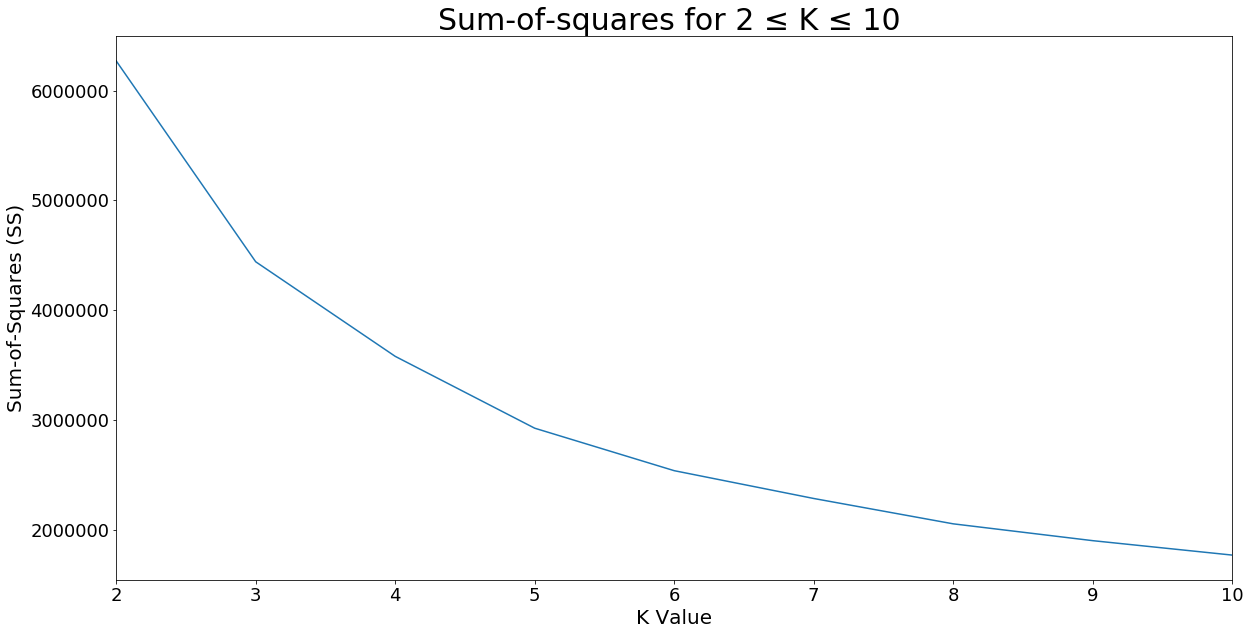

In [10]:
# Plot sum-of-squares against each k value
plt.figure(figsize=(20,10))
    
plt.plot(range(2, 11), ss_vals)
plt.xlim([2,10])
plt.xlabel('K Value', fontsize=20)
plt.ylabel('Sum-of-Squares (SS)', fontsize=20)
plt.xticks(range(2,11), size = 18)
plt.yticks(size = 18)
plt.title('Sum-of-squares for 2 ≤ K ≤ 10 ', size=30)
plt.show()

#### Response:
From the graph, it appears that the 'elbow point' where the graph descends slower is at k=5. However, the results are not conclusive so in order to test this against another method of choosing the best k-value, I will also use the silhouette method and compare the results.

# Choosing the appropriate *K* value: The Silhouette Method
I initially ran the Silhouette Method on the full Crime Data Warehouse dataset, and the runtime took multiple hours for larger k values. For testing purposes, I am deciding to focus on a smaller dataset of 5000 randomly sampled crime reports to run the Silhouette method on.

In [11]:
# Generate a smaller sample of the Crime Data Warehouse Data Frame for Silouette Method 
sample = cdw_df.sample(5000)

In [13]:
# Create dummy variables for categorical crime features to be used for k-means model
dummy_sample_df = pd.get_dummies(data=sample, columns=["Incident Category", "Incident Day of Week", "Police District"])
dummy_sample_cols = ["Incident Hour", "Incident Month", 'Incident Category_Arson', 'Incident Category_Assault',
       'Incident Category_Burglary', 'Incident Category_Case Closure',
       'Incident Category_Civil Sidewalks',
       'Incident Category_Courtesy Report',
       'Incident Category_Disorderly Conduct',
       'Incident Category_Drug Offense', 'Incident Category_Drug Violation',
       'Incident Category_Embezzlement', 'Incident Category_Family Offense',
       'Incident Category_Fire Report',
       'Incident Category_Forgery And Counterfeiting',
       'Incident Category_Fraud',
       'Incident Category_Human Trafficking (A), Commercial Sex Acts',
       'Incident Category_Juvenile Offenses',
       'Incident Category_Larceny Theft', 'Incident Category_Liquor Laws',
       'Incident Category_Lost Property',
       'Incident Category_Malicious Mischief',
       'Incident Category_Miscellaneous Investigation',
       'Incident Category_Missing Person',
       'Incident Category_Motor Vehicle Theft',
       'Incident Category_Motor Vehicle Theft?',
       'Incident Category_Non-Criminal',
       'Incident Category_Offences Against The Family And Children',
       'Incident Category_Other', 'Incident Category_Other Miscellaneous',
       'Incident Category_Other Offenses', 'Incident Category_Prostitution',
       'Incident Category_Rape', 'Incident Category_Recovered Vehicle',
       'Incident Category_Robbery', 'Incident Category_Sex Offense',
       'Incident Category_Stolen Property', 'Incident Category_Suspicious',
       'Incident Category_Suspicious Occ',
       'Incident Category_Traffic Collision',
       'Incident Category_Traffic Violation Arrest',
       'Incident Category_Vandalism', 'Incident Category_Vehicle Impounded',
       'Incident Category_Vehicle Misplaced', 'Incident Category_Warrant',
       'Incident Category_Weapons Carrying Etc',
       'Incident Category_Weapons Offense', 'Incident Day of Week_Friday',
       'Incident Day of Week_Monday', 'Incident Day of Week_Saturday',
       'Incident Day of Week_Sunday', 'Incident Day of Week_Thursday',
       'Incident Day of Week_Tuesday', 'Incident Day of Week_Wednesday',
       'Police District_Bayview', 'Police District_Central',
       'Police District_Ingleside', 'Police District_Mission',
       'Police District_Northern', 'Police District_Out of SF',
       'Police District_Park', 'Police District_Richmond',
       'Police District_Southern', 'Police District_Taraval',
       'Police District_Tenderloin']
dummy_sample_np_arr = dummy_sample_df[dummy_sample_cols].to_numpy()

For k = 2 The average silhouette_score is : 0.4236993615749844
For k = 3 The average silhouette_score is : 0.3472212284364549
For k = 4 The average silhouette_score is : 0.3179989075964697
For k = 5 The average silhouette_score is : 0.30813571819576807
For k = 6 The average silhouette_score is : 0.2963791325369993
For k = 7 The average silhouette_score is : 0.28615109009267226
For k = 8 The average silhouette_score is : 0.2722232592416055
For k = 9 The average silhouette_score is : 0.25392763028471166
For k = 10 The average silhouette_score is : 0.2507914194298365


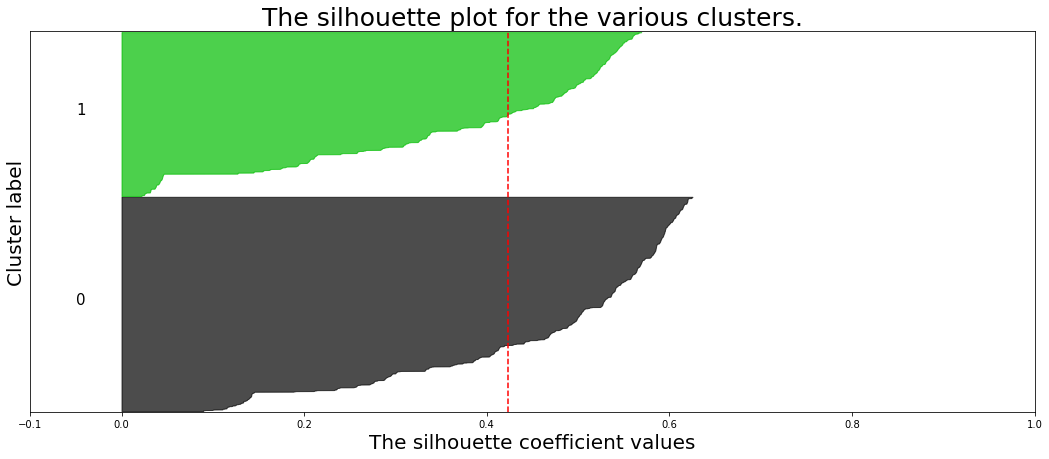

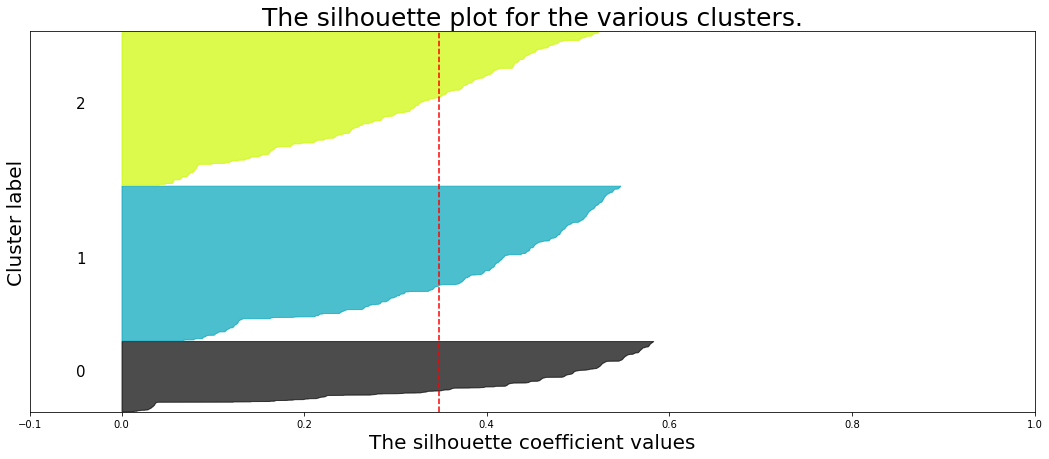

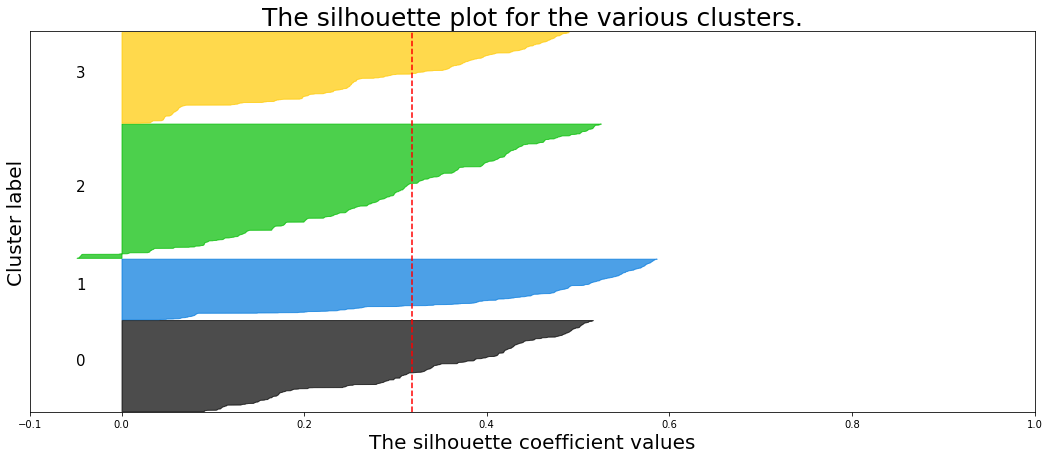

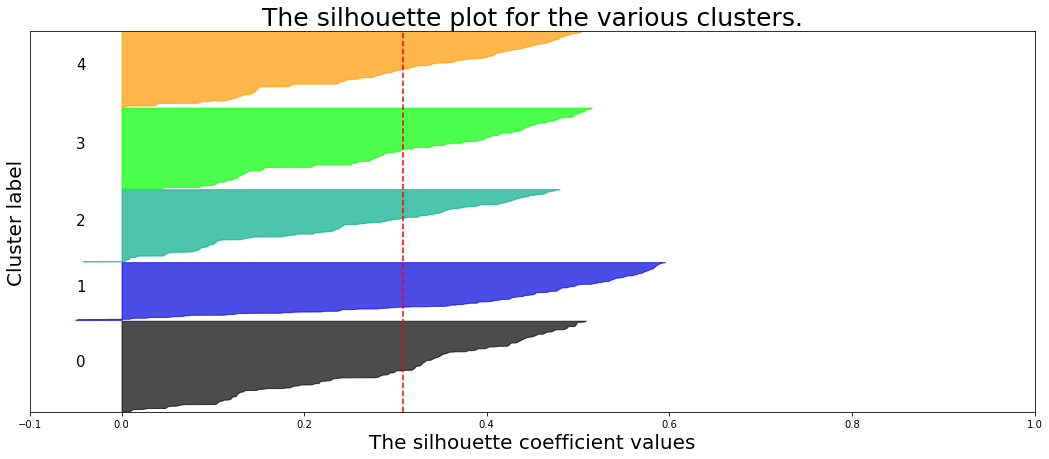

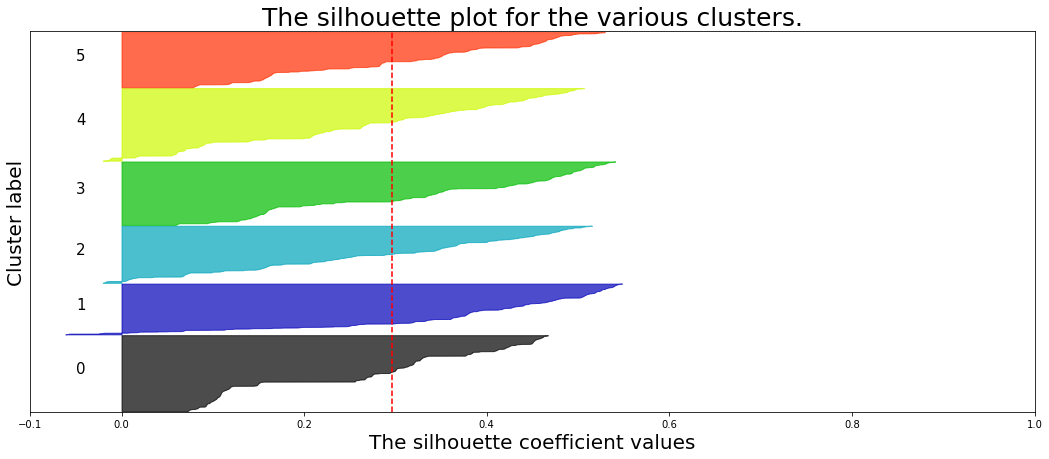

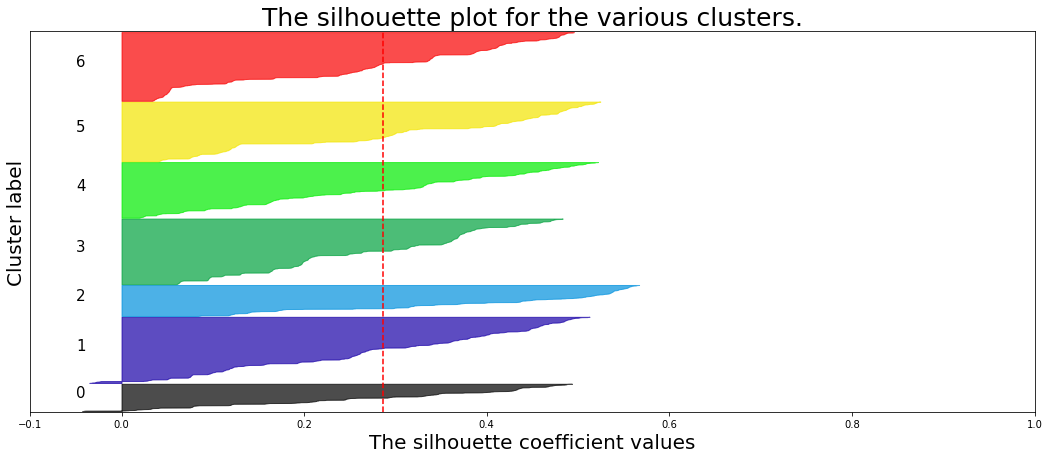

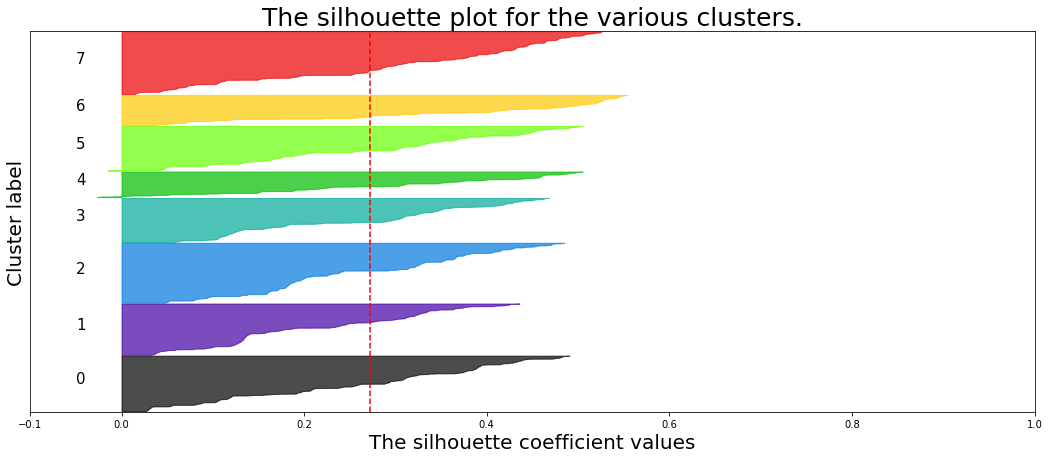

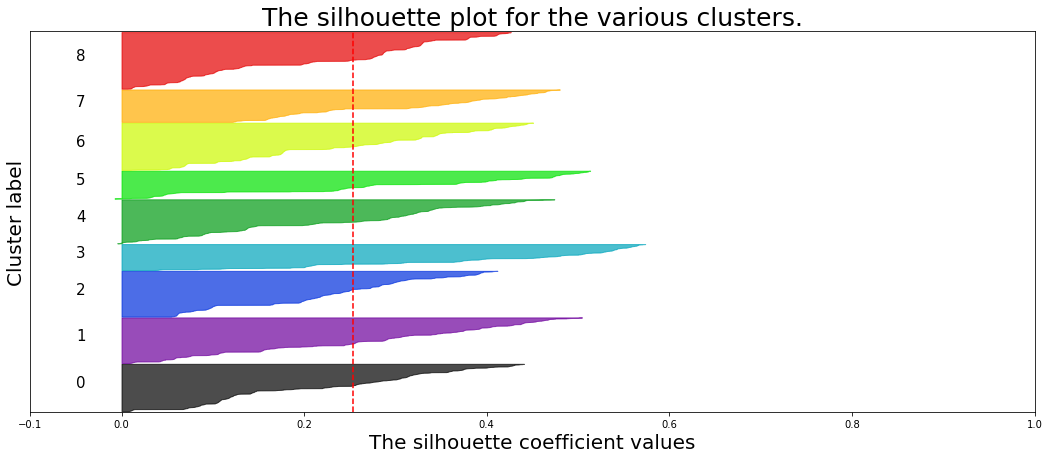

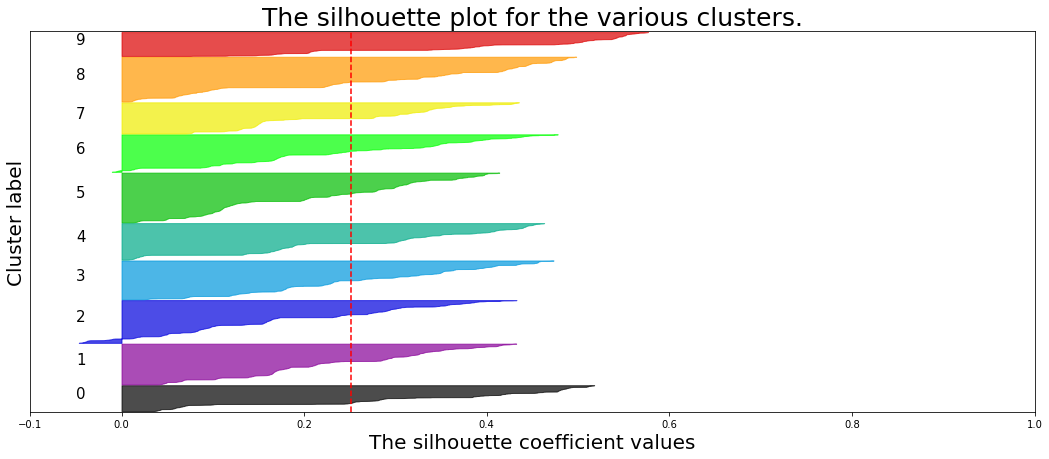

In [14]:
# The article from "https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html" was 
# used to help implement the loop

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

k_vals = range(2,11)
silhouette_scores = []

for num_clusters in k_vals:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dummy_sample_np_arr) + (num_clusters + 1) * 10])

    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=num_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dummy_sample_np_arr)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dummy_sample_np_arr, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For k =", num_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dummy_sample_np_arr, cluster_labels)

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=15)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=25)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=20)
    ax1.set_ylabel("Cluster label", fontsize=20)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

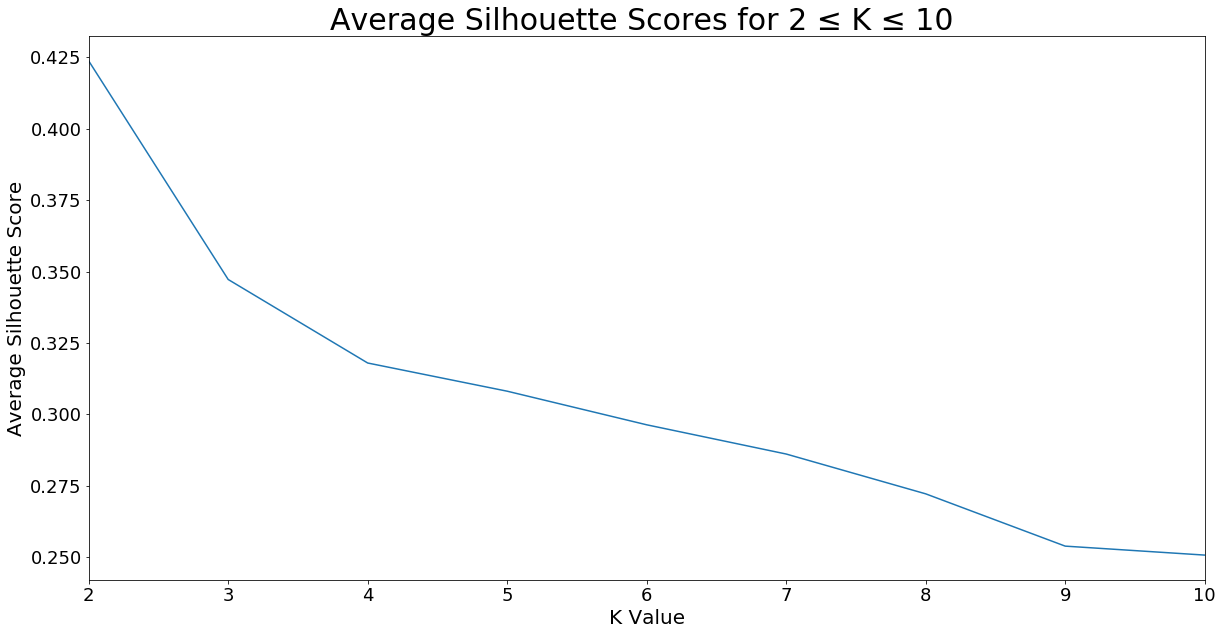

In [15]:
# Plot the average silhouette scores for 2<=k<=10
plt.figure(figsize=(20,10))
    
plt.plot(range(2, 11), silhouette_scores)
plt.xlim([2,10])
plt.xlabel('K Value', fontsize=20)
plt.ylabel('Average Silhouette Score', fontsize=20)
plt.xticks(range(2,11), size = 18)
plt.yticks(size = 18)
plt.title('Average Silhouette Scores for 2 ≤ K ≤ 10 ', size=30)
plt.show()

#### Response:
Although higher silhouette scores represent stronger clustering structures being found, it appears that the average silhouette score for k as k increases follows a similar shape to the sum-of-squares method. When k=5, the graph appears to level out a bit. I can use this value to build my baseline model and evaluate the resulting clusters.

# Building K-Means model with k=5

In [16]:
# Build KMeans model initialized with 4 clusters
model = KMeans(n_clusters = 5)
model.fit_predict(dummy_np_arr)

array([2, 2, 2, ..., 2, 0, 0])

In [17]:
# Get cluster assignments for each and add to Crime Data Warehouse Data Frame
cluster_assignments = model.labels_
cdw_df.loc[:,"cluster_id"] = cluster_assignments

C:\Users\Garrett\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Garrett\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


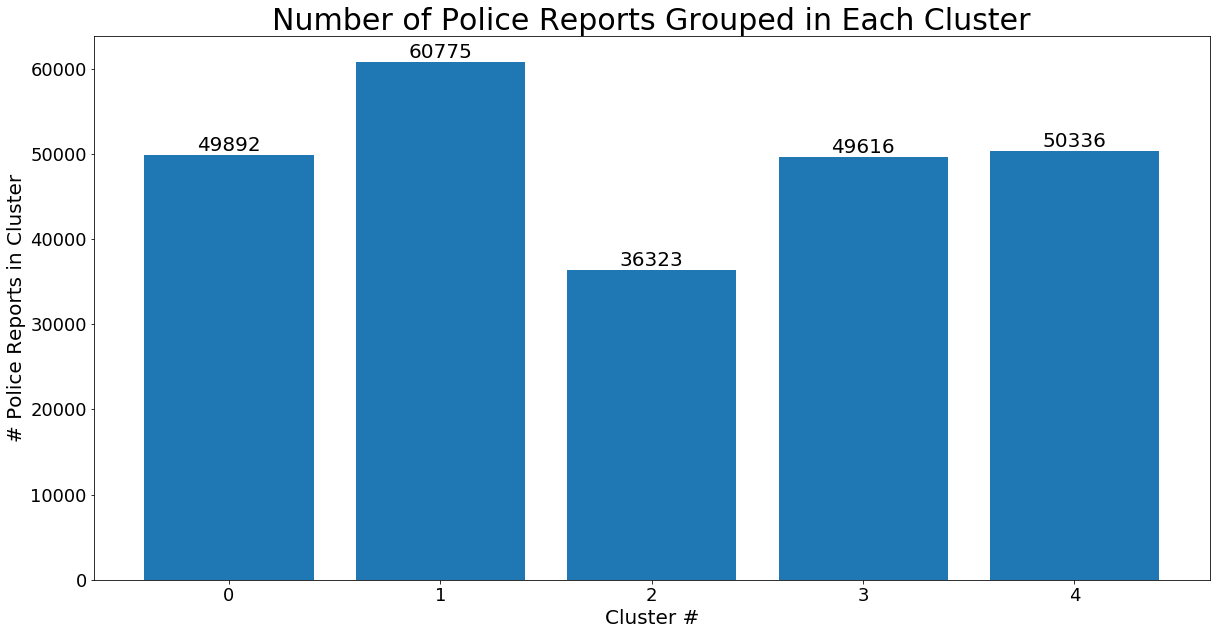

In [66]:
# Plot the bar chort of number of reports by cluster
plt.figure(figsize=(20,10))
plot = plt.bar(list(cdw_df.groupby('cluster_id').size().index), list(cdw_df.groupby('cluster_id').size().values),  align='center')
plt.xlabel('Cluster #', fontsize=20)
plt.ylabel('# Police Reports in Cluster', fontsize=20)
plt.xticks(range(0, 5), size = 18)
plt.yticks(size = 18)
plt.title('Number of Police Reports Grouped in Each Cluster', fontsize=30)

# Add crime total above each bar
for bar in plot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=20)
    
plt.show()

# Looking deeper into each cluster
Now that the Crime Data Warehouse crime reports have been grouped into different clusters, it is beneficial for me to apply similar exploratory data analysis on each individual cluster to see what distinguishes them from each other. Questions from my "Data Storytelling" notebook are going to drive my analysis to explore relationships between crimes within each cluster and how each cluster's features differ from one another.

In [20]:
# Set variables to represesnt each cluster
c0 = cdw_df[cdw_df.cluster_id == 0]
c1 = cdw_df[cdw_df.cluster_id == 1]
c2 = cdw_df[cdw_df.cluster_id == 2]
c3 = cdw_df[cdw_df.cluster_id == 3]
c4 = cdw_df[cdw_df.cluster_id == 4]

### What types of crimes are in each cluster?

In [21]:
def print_top_ten(categories, startyear, endyear):
    """Prints top ten most common categories from startyear to endyear and the corresponding percentage of all crimes reported"""
    
    print("Top Ten Crimes Reported from", startyear, "to", endyear, "\n")
    for category,count in Counter(categories.tolist()).most_common(10):
        print(category + ":", count, "reports -------", str(round(count / len(categories) * 100, 2)) + "%", "of all crimes reported")

In [22]:
def top_8_pie(cluster):
    """Plots pie chart of top 5 categories per cluster"""
    
    top_8 = Counter(cluster["Incident Category"].tolist()).most_common(8)
    
    categories = [x[0] for x in top_8]
    values = [x[1] for x in top_8]
    other_val = len(cluster) - sum(values)
    
    # Get 'other' category for crimes not in top 8
    categories.append("Other")
    values.append(other_val)
    
    # Plot pie chart
    plt.pie(values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Classification % Distribution", fontsize=20)

    plt.axis('equal')

In [23]:
print_top_ten(cdw_df["Incident Category"], 2018, 2019)

Top Ten Crimes Reported from 2018 to 2019 

Larceny Theft: 77832 reports ------- 31.52% of all crimes reported
Other Miscellaneous: 19099 reports ------- 7.73% of all crimes reported
Non-Criminal: 15417 reports ------- 6.24% of all crimes reported
Assault: 14866 reports ------- 6.02% of all crimes reported
Malicious Mischief: 14407 reports ------- 5.83% of all crimes reported
Burglary: 10950 reports ------- 4.43% of all crimes reported
Warrant: 9308 reports ------- 3.77% of all crimes reported
Lost Property: 9073 reports ------- 3.67% of all crimes reported
Motor Vehicle Theft: 8591 reports ------- 3.48% of all crimes reported
Fraud: 7326 reports ------- 2.97% of all crimes reported


Certain classes of crimes are so much more common than others, with Larcenty Theft accounting for 31.52% of all crimes from 2018-2019. Because of this, I will be looking not only at which classifications of crimes are the most common for each cluster, but also the percentage of each classification in relation to the number of reports in the corresponding cluster.

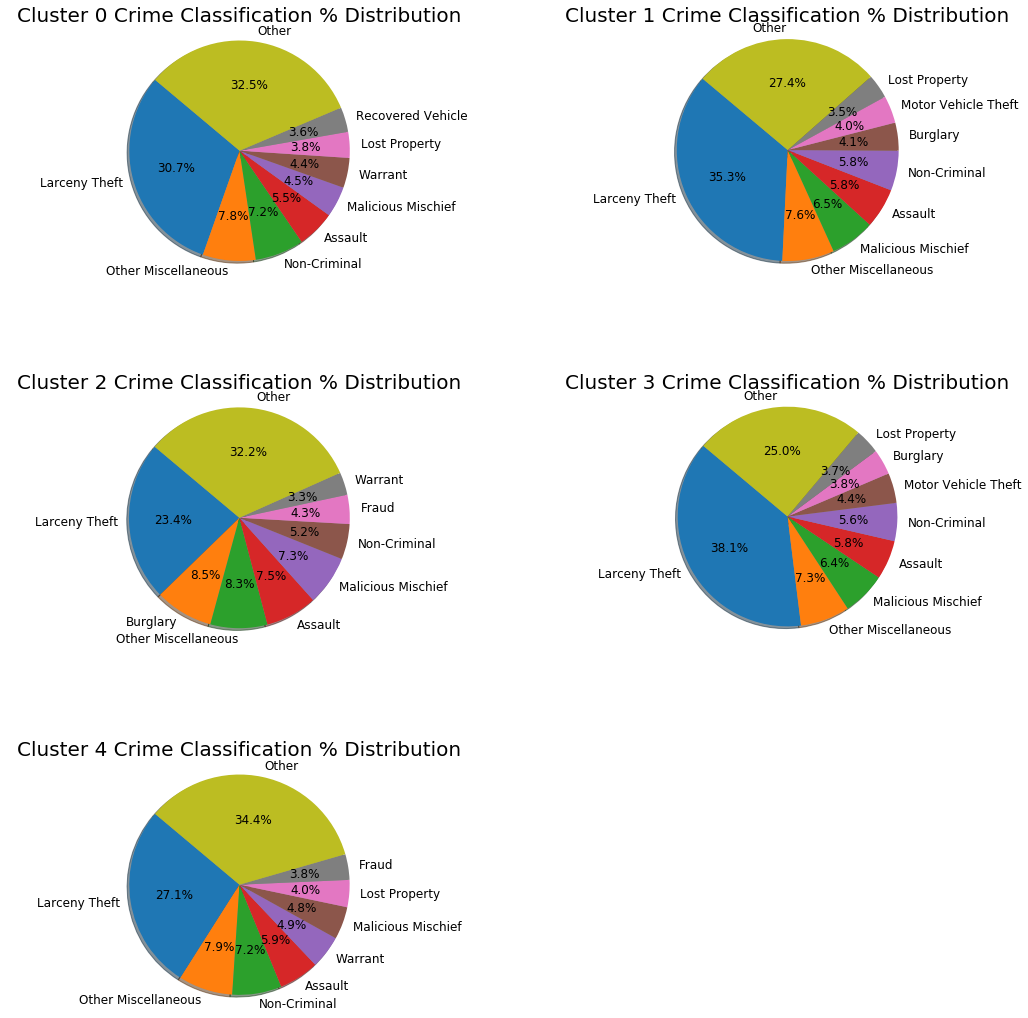

In [26]:
# Plot pie charts for each cluster's percentage distribution of crime classifications
fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
top_8_pie(c0)
plt.subplot2grid((3,2),(0,1))
top_8_pie(c1)
plt.subplot2grid((3,2),(1,0))
top_8_pie(c2)
plt.subplot2grid((3,2),(1,1))
top_8_pie(c3)
plt.subplot2grid((3,2),(2,0))
top_8_pie(c4)

## What days are crime reports most frequent in each cluster?

In [137]:
def plot_days(cluster):
    """Plots bar graph of crime reports per day for a given cluster"""
    
    # List of bar characteristics
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    totals = []
    colors = ['orange', 'y', 'green', 'blue', 'purple', 'black', 'red']

    for day in days:
        total = sum(cluster["Incident Day of Week"] == day)
        totals.append(total)
    
    # Plot bar graph and add grid
    plot = plt.bar(days, totals, color=colors, zorder=2)
    plt.grid(True)
    
    # Add title, axes labels, and adjust x and y ticks
    plt.title("Crime Reports by Day Cluster " + str(cluster.cluster_id.iloc[0]), fontsize=24)
    plt.xlabel("Day", fontsize=16)
    plt.ylabel("Number of Crime Reports", fontsize=16)
    plt.xticks(fontsize=13, rotation=45)
    plt.yticks(fontsize=13)
    plt.ylim(0,11000)

    # Add crime total above each bar
    for bar in plot:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=11)

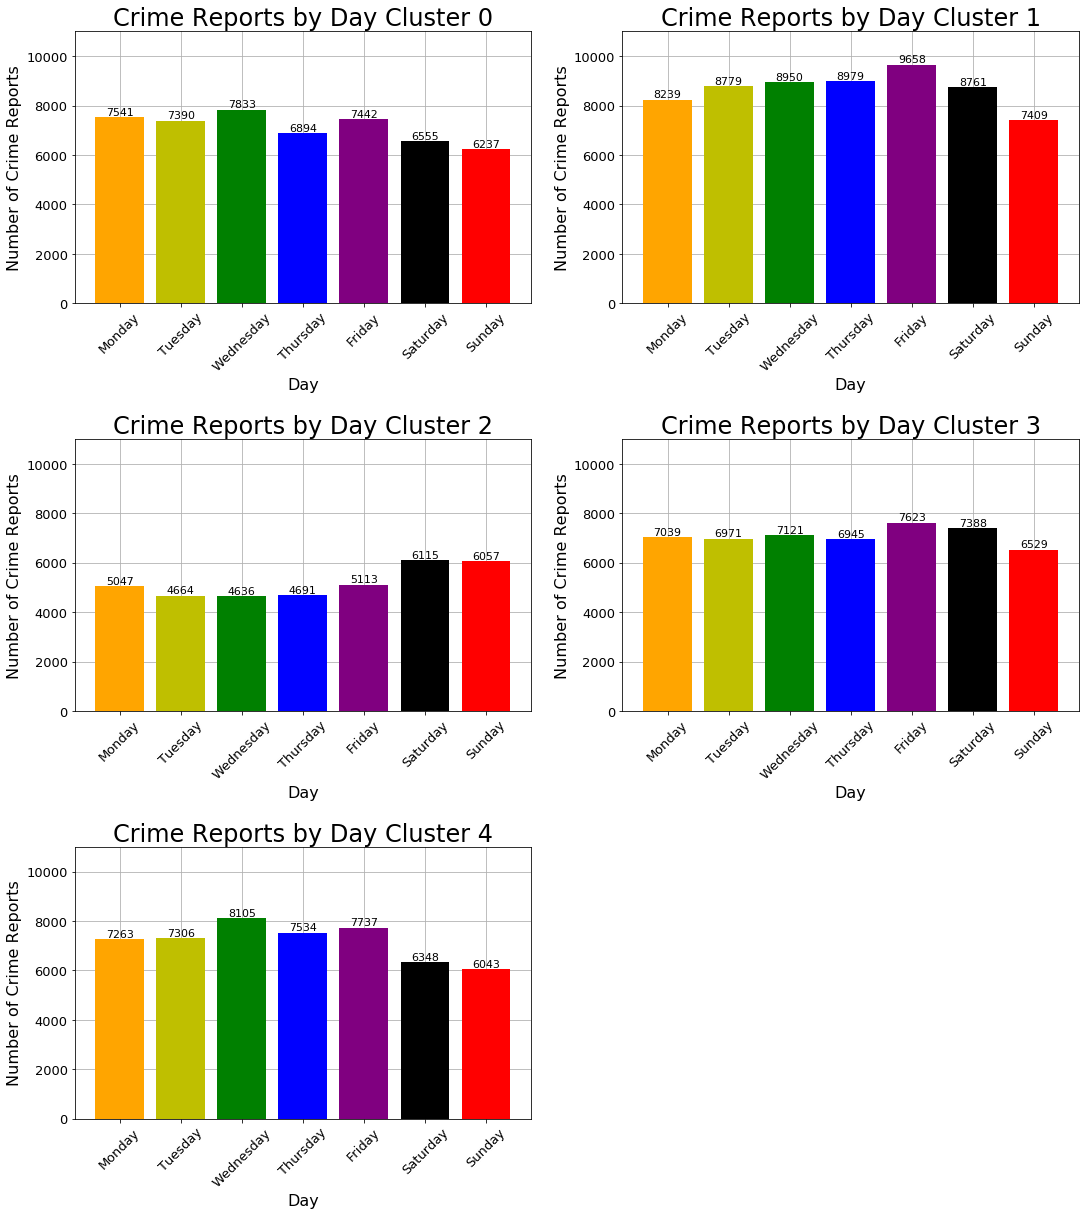

In [138]:
# Create figure to display crimes reported per day of the week for each cluster
fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
plot_days(c0)
plt.subplot2grid((3,2),(0,1))
plot_days(c1)
plt.subplot2grid((3,2),(1,0))
plot_days(c2)
plt.subplot2grid((3,2),(1,1))
plot_days(c3)
plt.subplot2grid((3,2),(2,0))
plot_days(c4)

## What times of the ***day*** are most common for crimes in each cluster?

In [134]:
def plot_times_per_day(cluster):
    """Plot the total number of reports for times of crimes"""
    time_categories = ["morning", "afternoon", "evening", "night"]
    xlabels = ["Morning\n(5:00am-11:59am)", "Afternoon\n(12:00pm-4:59pm)", "Evening\n(5:00pm-8:59pm)", "Night\n(9:00pm-4:49am)"]
    totals = []

    for tc in time_categories:
        totals.append(sum(cluster["Time Category"] == tc))

    plt.bar(xlabels, totals, color=('goldenrod', 'royalblue', 'maroon', 'k'))
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Report Times of Day", fontsize=23)
    plt.xlabel("Time Reported", fontsize=17)
    plt.ylabel("# Reports", fontsize=17)
    plt.ylim(0, 32500)
    plt.xticks(fontsize=12)

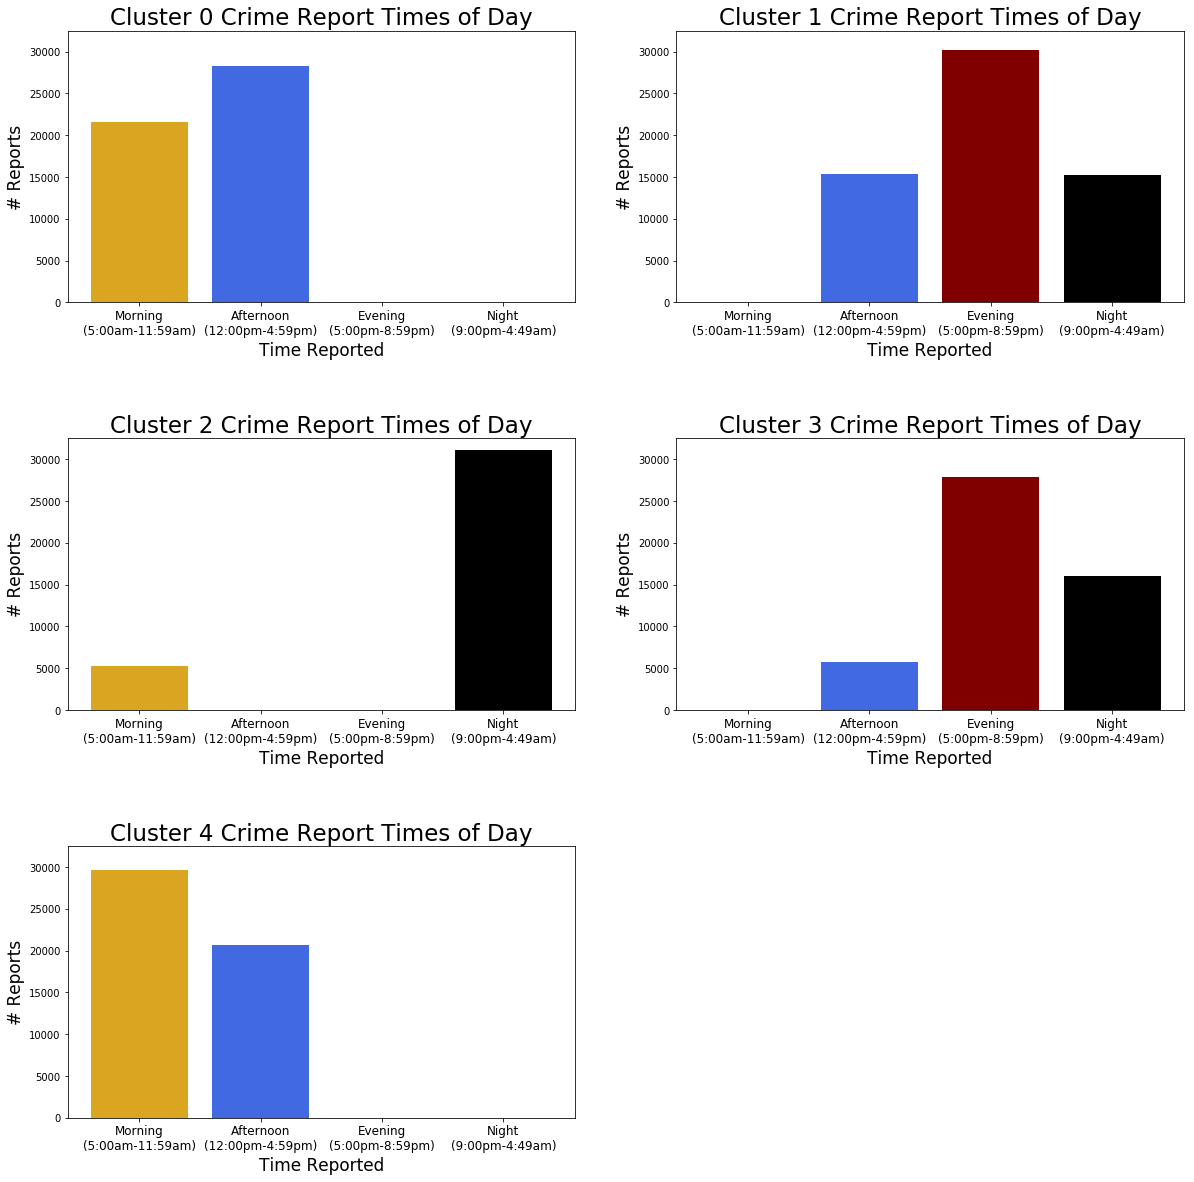

In [135]:
# Create figure to display crimes reported per day of the week for each cluster
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
plot_times_per_day(c0)
plt.subplot2grid((3,2),(0,1))
plot_times_per_day(c1)
plt.subplot2grid((3,2),(1,0))
plot_times_per_day(c2)
plt.subplot2grid((3,2),(1,1))
plot_times_per_day(c3)
plt.subplot2grid((3,2),(2,0))
plot_times_per_day(c4)


## What times of the ***year*** are most common for crimes in each cluster?

In [131]:
def plot_times_per_year(cluster):
    """Plot the total number of reports for each season per cluster"""
    seasons = ["spring", "summer", "fall", "winter"]
    xlabels = ["Spring\n(Mar-May)", "Summer\n(Jun-Aug)", "Fall\n(Sep-Nov)", "Winter\n(Dec-Feb)"]
    totals = []

    for s in seasons:
        totals.append(sum(cluster.Season == s))

    plt.bar(xlabels, totals, color=('springgreen', 'firebrick', 'darkorange', 'lightskyblue'))
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Reports per Season", fontsize=20)
    plt.xlabel("Season", fontsize=17)
    plt.ylabel("# Reports", fontsize=17)
    plt.ylim(0, 37500)
    plt.xticks(fontsize=12)

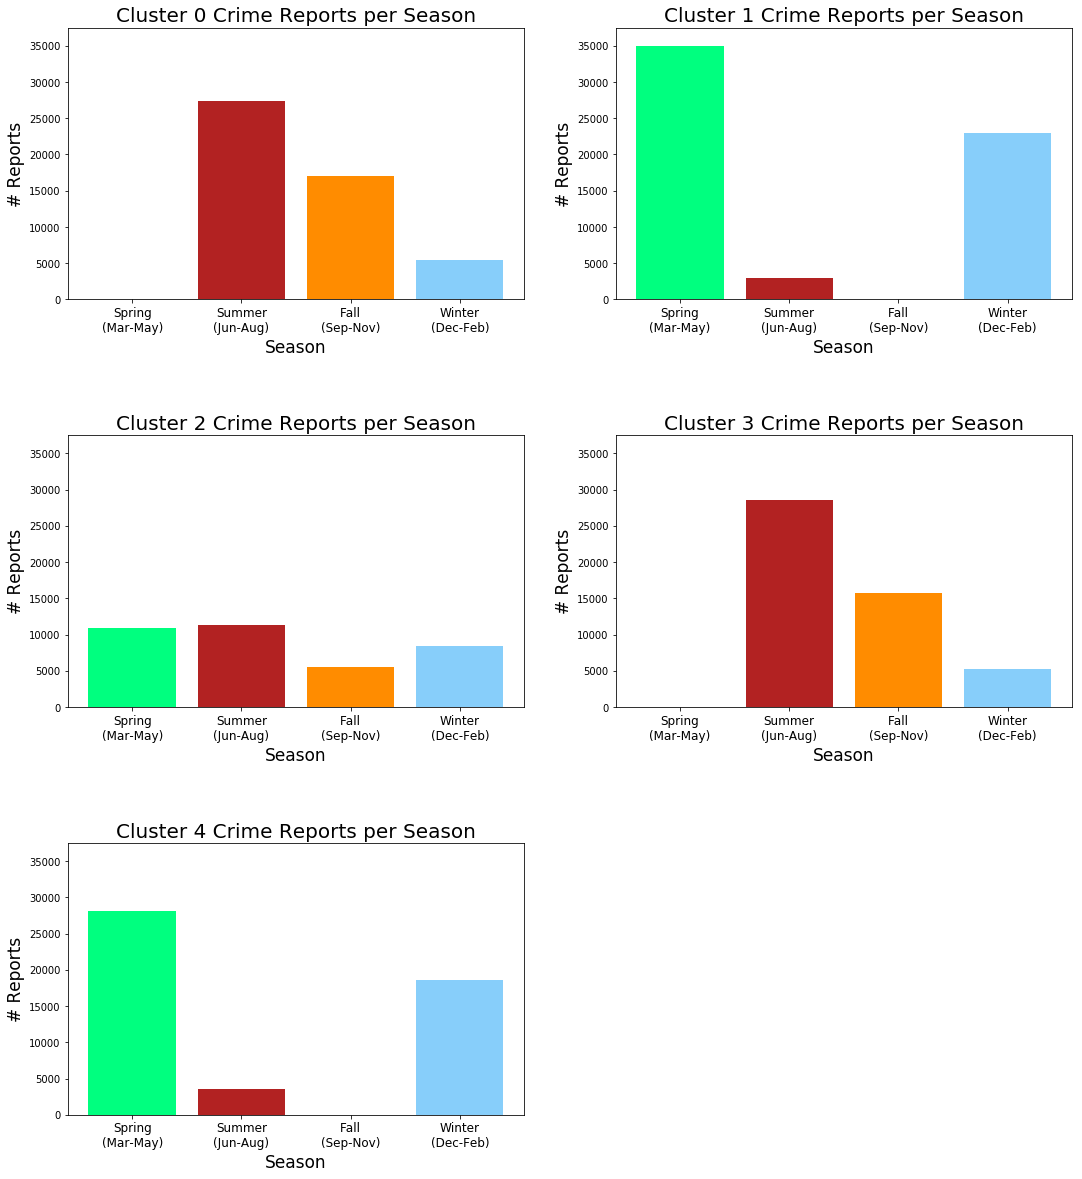

In [136]:
# Create figure to display crimes reported per season for each cluster
fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
plot_times_per_year(c0)
plt.subplot2grid((3,2),(0,1))
plot_times_per_year(c1)
plt.subplot2grid((3,2),(1,0))
plot_times_per_year(c2)
plt.subplot2grid((3,2),(1,1))
plot_times_per_year(c3)
plt.subplot2grid((3,2),(2,0))
plot_times_per_year(c4)

## Which police district crime reports are most frequent in each cluster?

In [145]:
def pd_top_5_pie(cluster):
    """Plots pie chart of top 5 police districts per cluster"""
    
    top_5 = Counter(cluster["Police District"].tolist()).most_common(5)
    
    categories = [x[0] for x in top_5]
    values = [x[1] for x in top_5]
    other_val = len(cluster) - sum(values)
    
    # Get 'other' category for crimes not in top 8
    categories.append("Other")
    values.append(other_val)
    
    # Plot pie chart
    plt.pie(values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Police District % Distribution", fontsize=20)

    plt.axis('equal')

In [151]:
cdw_df.groupby("cluster_id")["Police District"].apply(lambda x: x.value_counts().head(5))

cluster_id            
0           Central       8306
            Southern      5978
            Northern      5968
            Mission       5846
            Tenderloin    5834
1           Central       9707
            Mission       8448
            Northern      8211
            Southern      7852
            Tenderloin    5665
2           Mission       6243
            Central       5286
            Southern      4985
            Northern      4951
            Bayview       3104
3           Central       8970
            Mission       6907
            Northern      6736
            Southern      6206
            Tenderloin    4227
4           Central       7352
            Tenderloin    6364
            Southern      6185
            Northern      6134
            Mission       5982
Name: Police District, dtype: int64

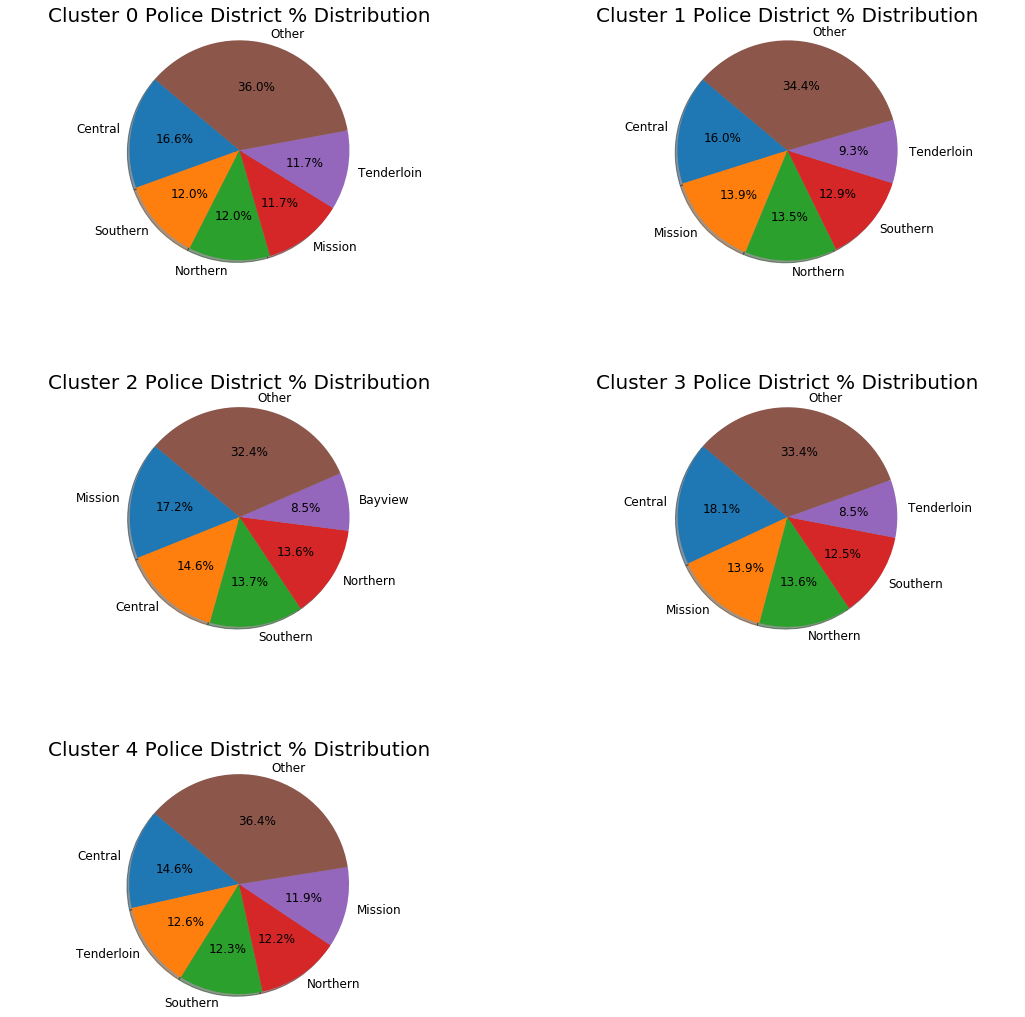

In [146]:
# Plot pie charts for each cluster's percentage distribution of police districts
fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
pd_top_5_pie(c0)
plt.subplot2grid((3,2),(0,1))
pd_top_5_pie(c1)
plt.subplot2grid((3,2),(1,0))
pd_top_5_pie(c2)
plt.subplot2grid((3,2),(1,1))
pd_top_5_pie(c3)
plt.subplot2grid((3,2),(2,0))
pd_top_5_pie(c4)